# **IMPORT LIBRARY**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import joblib

# **LOAD** **DATASET**

In [2]:
df = pd.read_csv('Nike Dataset.csv')
df.head()

,Invoice Date,Product,Region,Retailer,Sales Method,State,Price per Unit,Total Sales,Units Sold
0,01-01-2020,Men's Street Footwear,Northeast,Foot Locker,In-store,New York,50,6000,120
1,02-01-2020,Men's Athletic Footwear,Northeast,Foot Locker,In-store,New York,50,5000,100
2,03-01-2020,Women's Street Footwear,Northeast,Foot Locker,In-store,New York,40,4000,100
3,04-01-2020,Women's Athletic Footwear,Northeast,Foot Locker,In-store,New York,45,3825,85
4,05-01-2020,Men's Apparel,Northeast,Foot Locker,In-store,New York,60,5400,90


In [3]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9360 entries, 0 to 9359
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Invoice Date    9360 non-null   object
 1   Product         9360 non-null   object
 2   Region          9360 non-null   object
 3   Retailer        9360 non-null   object
 4   Sales Method    9360 non-null   object
 5   State           9360 non-null   object
 6   Price per Unit  9360 non-null   int64 
 7   Total Sales     9360 non-null   int64 
 8   Units Sold      9360 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 658.3+ KB


Index(['Invoice Date', 'Product', 'Region', 'Retailer', 'Sales Method',
       'State', 'Price per Unit', 'Total Sales', 'Units Sold'],
      dtype='object')

# **RENAME KOLOM**

In [8]:
df = df.rename(columns={
    'Invoice Date': 'date',
    'Units Sold': 'quantity_sold',
    'Total Sales': 'total_sales',
    'Price per Unit': 'price_per_unit'
})

In [9]:
df.columns

Index(['date', 'Product', 'Region', 'Retailer', 'Sales Method', 'State',
       'price_per_unit', 'total_sales', 'quantity_sold'],
      dtype='object')

# **PREPROCESSING** **DATA**

In [10]:
df = df.drop_duplicates()
df = df.dropna()

In [15]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df = df.sort_values('date')

In [16]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df[['date', 'month', 'year']].head()

,date,month,year
0,2020-01-01,1,2020
4783,2020-01-01,1,2020
4848,2020-01-01,1,2020
8241,2020-01-01,1,2020
8290,2020-01-01,1,2020


In [17]:
target = 'quantity_sold'
df[target].describe()

,quantity_sold
count,9360.000000
mean,25.852991
std,21.591922
min,0.000000
25%,11.000000
50%,18.000000
75%,35.000000
max,128.000000


# **EDA (EXPLORATORY DATA ANALYSIS)**

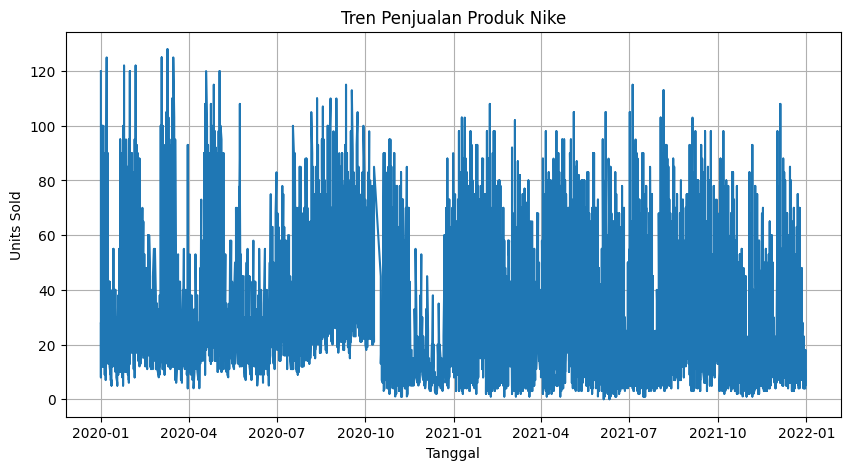

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df['date'], df[target])
plt.title("Tren Penjualan Produk Nike")
plt.xlabel("Tanggal")
plt.ylabel("Units Sold")
plt.grid()
plt.show()

# **DATA SPLIT (RANDOM FOREST)**

In [19]:
X_rf = df[['month', 'year', 'price_per_unit']]
y_rf = df[target]

from sklearn.model_selection import train_test_split

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf,
    y_rf,
    test_size=0.2,
    shuffle=False
)

# **MODEL RANDOM FOREST**

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train_rf, y_train_rf)
rf_pred = rf_model.predict(X_test_rf)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_rf = np.sqrt(mean_squared_error(y_test_rf, rf_pred))
mae_rf = mean_absolute_error(y_test_rf, rf_pred)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest MAE:", mae_rf)

Random Forest RMSE: 16.230370357025222
Random Forest MAE: 11.680999389244715


# **LSTM**
🔹 CELL — SCALING DATA

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[[target]])

scaled_data[:5]

array([[0.9375  ],
       [0.265625],
       [0.0625  ],
       [0.296875],
       [0.0625  ]])

🔹 CELL — MEMBUAT SEQUENCE (WINDOW)

In [23]:
def create_sequences(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled_data, window_size=10)

X_lstm.shape, y_lstm.shape

((9350, 10, 1), (9350, 1))

🔹 CELL — SPLIT TRAIN & TEST LSTM

In [24]:
split_index = int(0.8 * len(X_lstm))

X_train_lstm = X_lstm[:split_index]
X_test_lstm = X_lstm[split_index:]

y_train_lstm = y_lstm[:split_index]
y_test_lstm = y_lstm[split_index:]

🔹 CELL — BANGUN MODEL LSTM

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()
lstm_model.add(
    LSTM(
        50,
        input_shape=(X_train_lstm.shape[1], 1)
    )
)
lstm_model.add(Dense(1))

lstm_model.compile(
    optimizer='adam',
    loss='mse'
)

lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

🔹 CELL — TRAIN LSTM

In [26]:
history = lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0342 - val_loss: 0.0248
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0297 - val_loss: 0.0248
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0292 - val_loss: 0.0253
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0291 - val_loss: 0.0248
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0299 - val_loss: 0.0249
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0297 - val_loss: 0.0249
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0306 - val_loss: 0.0250
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0290 - val_loss: 0.0256
Epoch 9/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0285 - val_loss: 0.0250
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0299 - val_loss: 0.0252
Epoch 11/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0288 - val_loss: 0.0248
Epoch 12/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/s

🔹 CELL — EVALUASI LSTM

In [27]:
lstm_pred = lstm_model.predict(X_test_lstm)

rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, lstm_pred))
mae_lstm = mean_absolute_error(y_test_lstm, lstm_pred)

print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE:", mae_lstm)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
LSTM RMSE: 0.14750364740376468
LSTM MAE: 0.1278071528051626


# **PERBANDINGAN MODEL**

In [28]:
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'LSTM'],
    'RMSE': [rmse_rf, rmse_lstm],
    'MAE': [mae_rf, mae_lstm]
})

comparison

,Model,RMSE,MAE
0,Random Forest,16.230370,11.680999
1,LSTM,0.147504,0.127807


# **SIMPAN MODEL**

In [29]:
import joblib

lstm_model.save('model_lstm.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(rf_model, 'model_rf.pkl')

['model_rf.pkl']